In [ ]:
import pandas as pd
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import PorterStemmer
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
df = pd.read_csv('Sentiment_analysis_dataset.csv')
df = df.dropna(subset=['Statement', 'Status'])
df = df.drop(df[df.duplicated()][df[df.duplicated()]['Status'].isin(['Normal', 'Depression'])].index)
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df.apply(lambda row: augment_text(row['Statement'])
                                     if row['Status'] in ['Anxiety', 'Stress','Bipolar','Personality disorder'] else None, axis=1)
translated_rows = df[df['augmented_statement'].notna()]
translated_rows['Statement'] = translated_rows['augmented_statement']

df = pd.concat([df, translated_rows[['Statement', 'Status']]])

df = df.drop(columns=['augmented_statement'])

stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

stop_words = set(stopwords.words('english'))

def remove_stopwords_and_stem(text):
    tokens = word_tokenize(text)
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['Statement'] = df['Statement'].apply(lambda x: preprocess_text(x))
df['Statement'] = df['Statement'].apply(lambda x: remove_stopwords_and_stem(x))

label_encoder = LabelEncoder()
df['Status'] = label_encoder.fit_transform(df['Status'])

X = df['Statement']
y = df['Status']

vectorizer = TfidfVectorizer(
    max_features=5000,            
    stop_words='english'
)

X_tfidf = vectorizer.fit_transform(X).toarray()

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_tfidf_smote, y_tfidf_smote = smote.fit_resample(X_tfidf, y)


C:\Users\User\AppData\Local\Temp\ipykernel_25036\569600375.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_smote, y_tfidf_smote, test_size=0.3, random_state=42)

Accuracy: 0.8931726907630522
Model performance for Training set
- Root Mean Squared Error: 0.0992
- Mean Absolute Error: 0.0035
- R2 Score: 0.9975
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1.0997
- Mean Absolute Error: 0.3337
- R2 Score: 0.6986
Classification Report
                      precision    recall  f1-score   support

             Anxiety       0.94      0.97      0.96      3357
             Bipolar       0.97      0.98      0.98      3381
          Depression       0.77      0.65      0.71      3350
              Normal       0.85      0.92      0.89      3346
Personality disorder       1.00      0.99      0.99      3386
              Stress       0.96      0.96      0.96      3412
            Suicidal       0.74      0.77      0.76      3423

            accuracy                           0.89     23655
           macro avg       0.89      0.89      0.89     23655
        weighted avg       0.89      0.89      0.89     2365

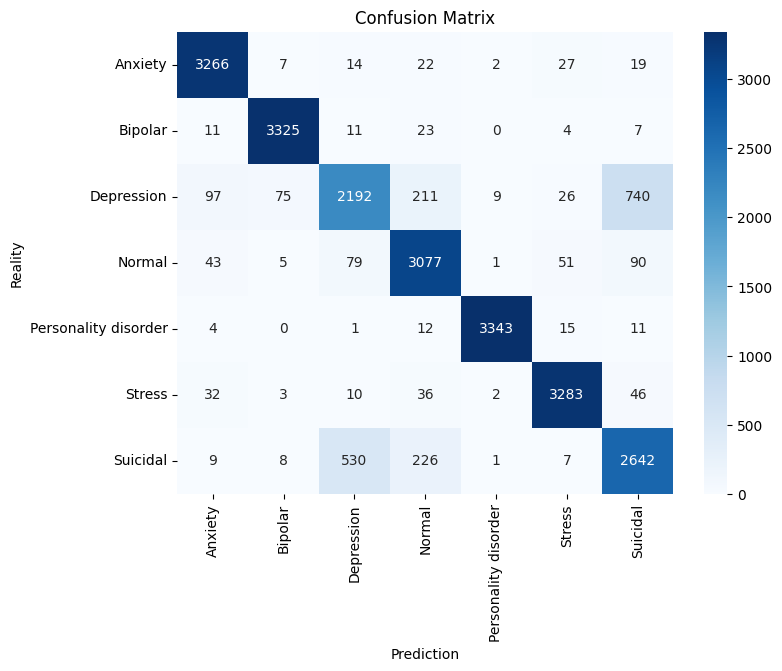

In [49]:
# Training model

model = RandomForestClassifier(n_estimators=100, random_state=42)

model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)
 # Make predictions
y_train_pred = model.predict(X_train_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

# Evaluate Train and Test dataset
model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_pred)

print('Model performance for Training set')
print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
print("- R2 Score: {:.4f}".format(model_train_r2))

print('----------------------------------')

print('Model performance for Test set')
print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
print("- R2 Score: {:.4f}".format(model_test_r2))

print("Classification Report")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.show()

In [61]:
# Make prediction
def predict_mental_health_status(text):
    # Vectorize the input text
    text_vec = vectorizer.transform([text])
    
    # Make the prediction
    prediction = model.predict(text_vec)
    
    # Convert the numerical prediction to the original category
    status = label_encoder.inverse_transform(prediction)
    
    return status[0]

# Example usage
text_1 = "This is really getting out of control I feel exhausted from the constant voices in my head and my heart racing during social situations. I feel like everything I do, could have been done better, and that I am inadequate. My avoidance is getting worse to the point where I am unable to do anything at all. As a medical student, I chose to study this major without truly understanding the challenges that would come with it. Now, during my clinical rotations, every encounter with each patient feels like a nightmare. I constantly feel judged, and I fear harsh criticism is always one step away from being directed at me. This constant mental battle leaves me with no room to use the knowledge that I have worked so hard to achieve."
result = predict_mental_health_status(text_1)
print(f"The predicted mental health status for the given text is: {result}")

text_2 = "I am feeling great and excited about the future."
result = predict_mental_health_status(text_2)
print(f"The predicted mental health status for the given text is: {result}")

text_3 = "I am feeling very anxious and stressed about work."
result = predict_mental_health_status(text_3)
print(f"The predicted mental health status for the given text is: {result}")

text_4 = "I don't see a reason to continue living, I just wanna die."
result = predict_mental_health_status(text_4)
print(f"The predicted mental health status for the given text is: {result}")

text_5 = "I act impulsively and regret it later."
result = predict_mental_health_status(text_5)
print(f"The predicted mental health status for the given text is: {result}")

text_6 = "The problem is, the mistakes I’ve made are the kind I can’t fix because I won’t be on shift to address them. I’m not sure what to say to be helpful or to ease the tension. I honestly feel like all my coworkers hate me, just like everyone else has. Ive already had three panic attacks at work."
result = predict_mental_health_status(text_6)
print(f"The predicted mental health status for the given text is: {result}")

text_7 = "I’m feeling completely overwhelmed right now. The constant voices in my head and my racing heart in social situations are exhausting. It feels like everything I do could have been done better, and that I’m just not good enough. My avoidance is worsening to the point where I can hardly do anything at all. As a medical student, I chose this path without truly grasping the challenges it would bring. Now, during my clinical rotations, every interaction with a patient feels like a nightmare. I constantly feel judged, and I’m always afraid that harsh criticism is just around the corner. This ongoing mental struggle leaves me no space to fully apply the knowledge I’ve worked so hard to gain."
result = predict_mental_health_status(text_7)
print(f"The predicted mental health status for the given text is: {result}")

text_8 = "i dont want to live this life, i just want to lay down without thinking about this life, i want to sleep under the tree for ever"
result = predict_mental_health_status(text_8)
print(f"The predicted mental health status for the given text is: {result}")

text_9 = "I really hate thinking about positive things and cant implement my ideas in real life"
result = predict_mental_health_status(text_9)
print(f"The predicted mental health status for the given text is: {result}")

The predicted mental health status for the given text is: Depression
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Anxiety
The predicted mental health status for the given text is: Suicidal
The predicted mental health status for the given text is: Normal
The predicted mental health status for the given text is: Stress
The predicted mental health status for the given text is: Depression
The predicted mental health status for the given text is: Depression
The predicted mental health status for the given text is: Depression
